In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [2]:
df_train = pd.read_csv("train.csv",index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')
df_gender_sub = pd.read_csv("sampleSubmission.csv", index_col='id')

In [3]:
#Create variable for test data filled with nan
df_test["target"] = np.nan

In [4]:
df_all = pd.concat([df_train, df_test])
df_all.shape

(17083, 231)

In [5]:
cat_obs = df_all.select_dtypes(include = ['object'].copy())
# converting to categorical data for faster computing purposes 
for i in cat_obs:
    cat_obs[i] = cat_obs[i].astype('category')

In [6]:
vars_all = df_all.columns.values
var_dep = ['target']



vars_ind = [var for var in vars_all if var not in (var_dep)]

In [7]:
vars_ind_numeric = list(df_all[vars_ind].columns[df_all[vars_ind].dtypes != 'object'])
vars_ind_categorical = list(df_all[vars_ind].columns[df_all[vars_ind].dtypes == 'object'])

In [9]:
h2o.init()
h2o.remove_all() 

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,08 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_gunnarwindsand_sfx2ci
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [10]:
h2o_df_all = h2o.H2OFrame(df_all[vars_ind + var_dep])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [11]:
# To use for predictions
h2o_train = h2o.import_file("train.csv")
h2o_test = h2o.import_file("test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
y = "target"
x = h2o_df_all.names 
x.remove(y)

In [13]:
train, valid, test = h2o_df_all.split_frame([0.75, 0.15 ])

In [14]:
train["target"] = train["target"].asfactor()
valid["target"] = valid["target"].asfactor()
test["target"] = test["target"].asfactor()

In [16]:
glm1 = H2OGeneralizedLinearEstimator(alpha=1,
                                     family="binomial",
                                      standardize = True,
                                     link="logit",
                                     lambda_search=True,
                                     seed=1)

In [17]:
glm1.train(x=x, y=y, training_frame=train, validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [18]:
glm1.model_performance(train).auc()

0.8784658075996771

In [19]:
glm1.model_performance(test).auc()

0.8513396715643907

In [21]:
glm1.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2285329088599211: 


,0,1,Error,Rate
0,7618.0,487.0,0.0601,(487.0/8105.0)
1,363.0,460.0,0.4411,(363.0/823.0)
Total,7981.0,947.0,0.0952,(850.0/8928.0)


### Glm2

In [25]:
from h2o.grid.grid_search import H2OGridSearch

hyper_parameters = { 'alpha': [0.01,0.1,0.3,0.5,0.7,0.9],
                     'lambda': [1e-4,1e-5,1e-6,1e-7,1e-8] }
search_criteria = { 'strategy': "RandomDiscrete", 'seed': 1,
                    'stopping_metric': "AUC",
                    'stopping_tolerance': 0.001,
                    'stopping_rounds': 2 }
glm2 = H2OGridSearch(H2OGeneralizedLinearEstimator(family='binomial', nfolds=5),
      hyper_parameters,
      grid_id="glm2",
      search_criteria=search_criteria)
glm2.train(x=x,y=y, training_frame=train)

glm Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: alpha, [0.5]
Hyper-parameter: lambda, [1e-07]
failure_details: class hex.glm.GLMModel glm2_model_1 is already in use.  Unable to use it now.  Consider using a different destination name.
failure_stack_traces: java.lang.IllegalArgumentException: class hex.glm.GLMModel glm2_model_1 is already in use.  Unable to use it now.  Consider using a different destination name.
	at water.Lockable$PriorWriteLock.atomic(Lockable.java:119)
	at water.Lockable$PriorWriteLock.atomic(Lockable.java:108)
	at water.TAtomic.atomic(TAtomic.java:17)
	at water.Atomic.compute2(Atomic.java:56)
	at water.Atomic.fork(Atomic.java:39)
	at water.Atomic.invoke(Atomic.java:31)
	at water.Lockable.write_lock(Lockable.java:61)
	at water.Lockable.delete_and_lock(Lockable.java:70)
	at hex.glm.GLM.buildModel(GLM.java:566)
	at hex.glm.GLM.init(GLM.java:556)
	at hex.glm.GLM.computeCrossVal

In [26]:
glm2.show()
print(glm2.sort_by('F1', False))

       alpha    lambda      model_ids              logloss
0      [0.7]  [1.0E-4]  glm2_model_28  0.23182413840042188
1      [0.9]  [1.0E-4]  glm2_model_12  0.23353611885120112
2      [0.5]  [1.0E-4]  glm2_model_13  0.23537745708065902
3      [0.3]  [1.0E-4]  glm2_model_19   0.2378087666065096
4     [0.01]  [1.0E-4]  glm2_model_20  0.23936028094354223
5      [0.1]  [1.0E-4]  glm2_model_15  0.23960471838012007
6      [0.5]  [1.0E-5]  glm2_model_25  0.24611863101540102
7      [0.9]  [1.0E-5]  glm2_model_27  0.24706303908128704
8     [0.01]  [1.0E-5]  glm2_model_11  0.24825998340879732
9      [0.7]  [1.0E-5]  glm2_model_21  0.24847662450535676
10     [0.1]  [1.0E-5]  glm2_model_23  0.24887067376873773
11     [0.3]  [1.0E-5]   glm2_model_4  0.24906717904913112
12    [0.01]  [1.0E-6]  glm2_model_24   0.2526213067191588
13     [0.1]  [1.0E-6]  glm2_model_16   0.2534200764456941
14     [0.7]  [1.0E-6]  glm2_model_18  0.25387407930009137
15    [0.01]  [1.0E-7]  glm2_model_17  0.254044242872637

Model Id,"Hyperparameters: [alpha, lambda]",F1
glm2_model_11,"[0.01, 1e-05]","[[0.3107915552652147, 0.5685149776927979]]"
glm2_model_4,"[0.3, 1e-05]","[[0.30789293542879653, 0.5676190476190476]]"
glm2_model_23,"[0.1, 1e-05]","[[0.3077467191779241, 0.5674300254452926]]"
glm2_model_26,"[0.9, 1e-06]","[[0.304767295961698, 0.5708931917551531]]"
glm2_model_22,"[0.9, 1e-07]","[[0.3033245933087322, 0.5705368289637953]]"
---,---,---
glm2_model_20,"[0.01, 0.0001]","[[0.2446762597832381, 0.5594087549744172]]"
glm2_model_15,"[0.1, 0.0001]","[[0.24146230505138094, 0.5559322033898305]]"
glm2_model_12,"[0.9, 0.0001]","[[0.23635586650297102, 0.5458663646659117]]"
glm2_model_28,"[0.7, 0.0001]","[[0.23602554547929863, 0.5476056338028168]]"



See the whole table with table.as_data_frame()



In [27]:
best_glm2 = glm2[0]

In [28]:
best_glm2.model_performance(train).auc()

0.890486948713086

In [29]:
best_glm2.model_performance(test).auc()

0.8404329752644359

In [30]:
best_glm2.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23602554547929863: 


,0,1,Error,Rate
0,7639.0,466.0,0.0575,(466.0/8105.0)
1,337.0,486.0,0.4095,(337.0/823.0)
Total,7976.0,952.0,0.0899,(803.0/8928.0)


### Glm3 

In [63]:
hyper_parameters = {'alpha': [0.01,0.3,0.5, 0.7, 0.9], 'lambda': [1e-5,1e-6,1e-7,1e-8,1e-9 ]}
# test search_criteria plumbing and max_models
search_criteria = { 'strategy': "RandomDiscrete",
                   'stopping_metric': "AUC",
                   'max_models': 5,
                  "seed": 1}
glm3 = H2OGridSearch(H2OGeneralizedLinearEstimator(family='binomial'),
                             hyper_parameters,grid_id="glm3", search_criteria=search_criteria)
glm3.train(x=x,y=y, training_frame=train)


glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [64]:
glm3.show()
print(glm3.grid_id)
print(glm3.sort_by('F1', False))
assert len(glm3.models) == 5, "expected 5 models, got: {}".format(len(glm3.models))
print(glm3.sorted_metric_table())
print(glm3.get_grid("r2"))

       alpha    lambda      model_ids              logloss
0     [0.01]  [1.0E-9]   glm3_model_6  0.19139885791055483
1     [0.01]  [1.0E-9]  glm3_model_30  0.19139885791055483
2      [0.3]  [1.0E-9]  glm3_model_35  0.19139949135813586
3      [0.5]  [1.0E-9]  glm3_model_33  0.19139977168708702
4      [0.7]  [1.0E-9]  glm3_model_21  0.19139999724310547
5      [0.9]  [1.0E-9]  glm3_model_22   0.1914001784108692
6      [0.9]  [1.0E-9]   glm3_model_7   0.1914001784108692
7     [0.01]  [1.0E-8]  glm3_model_14  0.19140126511086716
8     [0.01]  [1.0E-8]  glm3_model_17  0.19140126511086716
9      [0.3]  [1.0E-8]  glm3_model_24  0.19140345375762272
10     [0.5]  [1.0E-8]   glm3_model_3   0.1914036739667621
11     [0.5]  [1.0E-8]  glm3_model_32   0.1914036739667621
12     [0.5]  [1.0E-8]  glm3_model_19   0.1914036739667621
13     [0.7]  [1.0E-8]   glm3_model_8  0.19140387133953568
14     [0.9]  [1.0E-8]  glm3_model_31  0.19140397758590633
15    [0.01]  [1.0E-7]   glm3_model_2  0.191424220586095

Model Id,"Hyperparameters: [alpha, lambda]",F1
glm3_model_13,"[0.01, 1e-05]","[[0.3107915552652147, 0.5685149776927979]]"
glm3_model_1,"[0.3, 1e-05]","[[0.30789293542879653, 0.5676190476190476]]"
glm3_model_20,"[0.3, 1e-05]","[[0.30789293542879653, 0.5676190476190476]]"
glm3_model_26,"[0.9, 1e-06]","[[0.304767295961698, 0.5708931917551531]]"
glm3_model_29,"[0.7, 1e-07]","[[0.30330673640070654, 0.5705368289637953]]"
---,---,---
glm3_model_21,"[0.7, 1e-09]","[[0.2452240900418963, 0.5707915273132663]]"
glm3_model_33,"[0.5, 1e-09]","[[0.24522248739120162, 0.5707915273132663]]"
glm3_model_35,"[0.3, 1e-09]","[[0.2452203408772389, 0.5707915273132663]]"
glm3_model_30,"[0.01, 1e-09]","[[0.24521613097297726, 0.5707915273132663]]"



See the whole table with table.as_data_frame()



AssertionError: expected 5 models, got: 35

In [ ]:
best_glm3 = glm3[0]

In [ ]:
best_glm3.model_performance(train).auc()

In [ ]:
best_glm3.model_performance(test).auc()

In [62]:
best_glm3.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24521613097297726: 


,0,1,Error,Rate
0,7646.0,459.0,0.0566,(459.0/8105.0)
1,311.0,512.0,0.3779,(311.0/823.0)
Total,7957.0,971.0,0.0862,(770.0/8928.0)


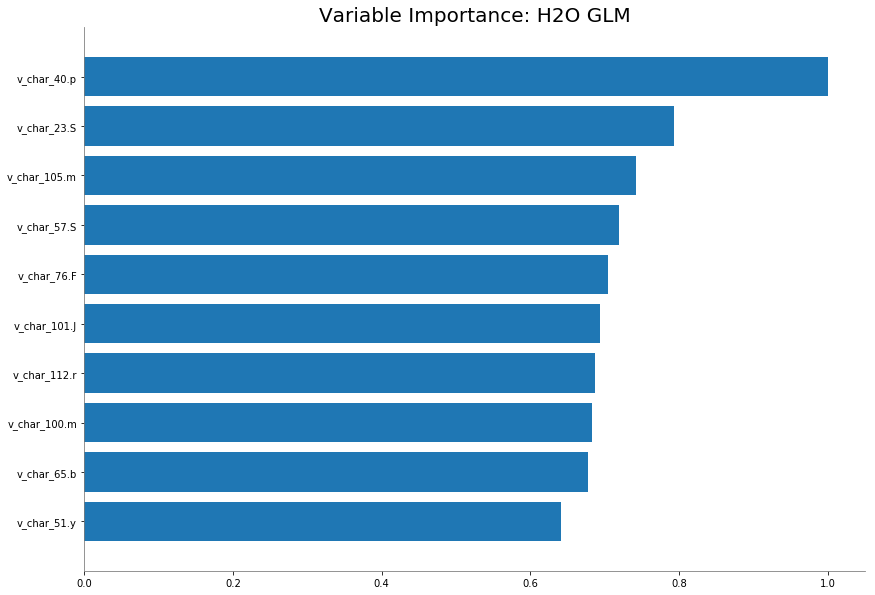

In [47]:
best_glm3.varimp_plot()

In [48]:
df_coef= pd.Series(best_glm3.coef())
df_coef= df_coef[np.abs(df_coef) > 0]
df_coef.head()

Intercept       4.623442
v_char_100.A   -0.914313
v_char_100.B   -4.379592
v_char_100.E   -2.953014
v_char_100.G   -4.502447
dtype: float64

In [49]:
df_coef.shape

(581,)

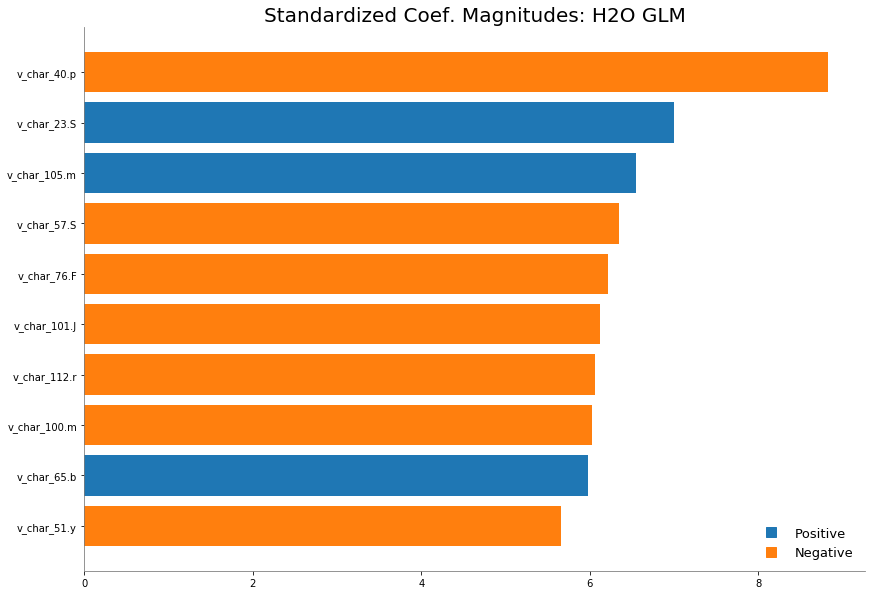

In [50]:
best_glm3.std_coef_plot(num_of_features=10)

In [65]:
best_glm3_path = h2o.save_model(model=best_glm3, force=True) #glm_3_model_6

In [51]:
predictions = best_glm3.predict(test_data=h2o_test)
submission = pd.read_csv('sampleSubmission.csv')
# Using fraud as indicator
submission['target'] = predictions['p1'].as_data_frame()
submission.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,id,target
0,5,0.092825
1,10,0.076578
2,11,0.049579
3,13,0.110317
4,16,0.016491


In [ ]:
submission.to_csv('glm_20_submission.csv', index = False)
submission.head()

In [70]:
h2o.cluster().shutdown()